In [2]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [3]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
data = torch.tensor(iris[iris.columns[0:4]].values).float()

In [6]:
labels = torch.zeros(len(data),dtype=torch.long)
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2
labels.unique()

tensor([0, 1, 2])

In [7]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size = .8)

In [9]:
train_dataDS = TensorDataset(train_data,train_labels)
test_dataDS = TensorDataset(test_data,test_labels)

In [10]:
train_loader = DataLoader(train_dataDS,batch_size=64,shuffle=True,drop_last = True)
test_loader = DataLoader(test_dataDS,batch_size=test_dataDS.tensors[0].shape[0])

In [15]:
def createANewModel(L2lambda):
    
    ANNiris = nn.Sequential(nn.Linear(4,64),
                           nn.ReLU(),
                           nn.Linear(64,64),
                           nn.ReLU(),
                           nn.Linear(64,3))
    
    lossfun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005,weight_decay = L2lambda)
    
    return ANNiris,lossfun,optimizer
    

In [27]:
numepochs = 1000

def trainTheModel():
    
    trainAcc = []
    testAcc = []
    losses = []
    
    for epochi in range(numepochs):
        
        batchAcc = []
        batchLoss = []
        
        for X,y in train_loader:
            
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)== y).float()).item())
            batchLoss.append(loss.item())
        
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        
        ANNiris.eval()
        X,y = next(iter(test_loader))
        predlabels = torch.argmax(ANNiris(X),axis=1)
        testAcc.append(100*torch.mean((predlabels == y).float()).item())
        ANNiris.train()
    
    return trainAcc,testAcc,losses

In [28]:
L2lambda = .01
ANNiris,lossfun,optimizer = createANewModel(L2lambda)
trainAcc,testAcc,losses = trainTheModel()

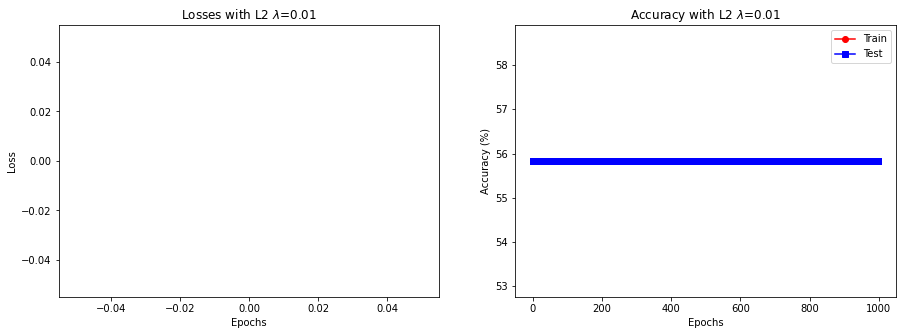

In [29]:
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show();